# Detector de fuegos por medio del uso de IA en plataforma Arduino NANO
Abajo se definirá primero los requisitos necesarios para poder instanciar la red neuronal de tensorflow, así como las instalaciones pertinentes que debe tener la máquina virtual dentro de este ambiente virtual. Las dependencias que requiere el sistema son las siguientes:

In [ ]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

Ahora se van a definir las primeras instancias del programa:

In [ ]:
# Se imporan las bibliotecas necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput

#Esto será relevante más adelante para la exportación a tensorflow lite
print(f"Versión de tensorflow = {tf.__version__}")

#Primero se va a definir una semilla aleatoria que no cambie cada vez que se instancie el programa dentro del notebook
semilla = 6942
np.random.seed(semilla)
tf.random.set_seed(semilla)

CLASSES = []
#Se van a buscar todos los archivos con extensión .csv en el directorio del collab para así poder tomar los datos de muestra
for file in os.listdir("/content/"):
  if file.endswith(".csv"):
    CLASSES.append(os.path.splitext(file)[0])
CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)


Versión de tensorflow = 2.12.0


[32,4mFire class will be output 0 of the classifier
6267 samples captured for training with inputs ['Red', 'Green', 'Blue']



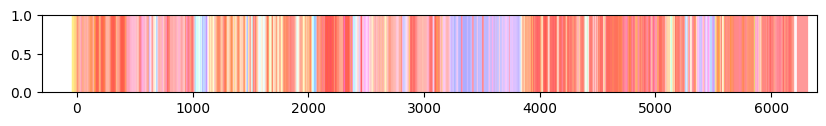

[32,4mnoFire class will be output 1 of the classifier
6368 samples captured for training with inputs ['Red', 'Green', 'Blue']



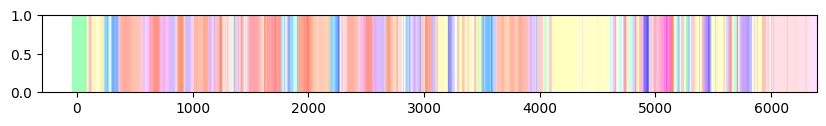

La preparacion y el analisis de datos se completa satisfactoriamente
Se organizaron los datos arbitrariamente en los sets: 'training, testing y validation' con exito.


In [ ]:
#Se crea un one-hot para representar los datos y y leer cada conjunto para saber cuantos sets hay

ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)
inputs = []
outputs = []

#Leer cada csv para obtener un input y un output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv('/content/'+objectClass+'.csv')
  columns = list(df)

  df = df.dropna()
  df = df.reset_index(drop=True)

  num_recordings = int(df.shape[0]/SAMPLES_WINDOW_LEN)
  print(f'\u001b[32,4m{objectClass}\u001b[0n class will be output \u001b[32m{class_index}\u001b[0m of the classifier')
  print(f'{num_recordings} samples captured for training with inputs {list(df)}\n')

# Se grafican los datos
  plt.rcParams["figure.figsize"] =(10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i,linewidth=8,color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()

  #Tensores
  output = ONE_HOT_ENCODED_CLASSES[class_index]

  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

#Se realiza la conversion de las listas
inputs = np.array(inputs)
outputs = np.array(outputs)

print("La preparacion y el analisis de datos se completa satisfactoriamente")

#La lista input se vuelve arbitraria para que los datos se organicen para el entrenamiento, las pruebas y la validacion
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

#Se hace la distribucion de grupos para en los tres sets: training, testing y validation
TRAIN_SPLIT = int(0.6*num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Se organizaron los datos arbitrariamente en los sets: 'training, testing y validation' con exito.")


In [ ]:

#Definición del modelo de tensorflow:
modelo = tf.keras.Sequential()
#Definición de la capa 1
modelo.add(tf.keras.layers.Dense(8, activation='relu'))
#Definición de la capa 2
modelo.add(tf.keras.layers.Dense(5, activation='relu'))
#Definición de la capa 3, con una neurona por cada salida deseada.
modelo.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
modelo.compile(optimizer='rmsprop', loss='mse')
history = modelo.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))


Epoch 1/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.2345 - val_loss: 0.2129
Epoch 2/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.2031 - val_loss: 0.1908
Epoch 3/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.1951 - val_loss: 0.1884
Epoch 4/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.1941 - val_loss: 0.1882
Epoch 5/400
1896/1896 [==============================] - 2s 1ms/step - loss: 0.1934 - val_loss: 0.1866
Epoch 6/400
1896/1896 [==============================] - 2s 1ms/step - loss: 0.1926 - val_loss: 0.1877
Epoch 7/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.1920 - val_loss: 0.1864
Epoch 8/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.1918 - val_loss: 0.1850
Epoch 9/400
1896/1896 [==============================] - 3s 1ms/step - loss: 0.1914 - val_loss: 0.1873
Epoch 10/400
1896/1896 [==============================] - 3s 1ms/step - l

79/79 [==============================] - 0s 3ms/step
Predicciones = 
 [[0.059 0.941]
 [0.433 0.567]
 [0.94  0.06 ]
 ...
 [0.059 0.941]
 [0.989 0.011]
 [0.372 0.628]]
actual =
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


ValueError: ignored

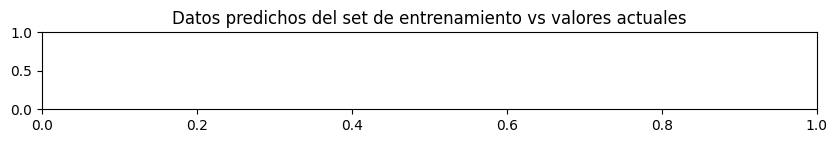

In [ ]:
#El modelo es utilizado para realizar las predicciones de los input de prueba
predictions = modelo.predict(inputs_test)

print("Predicciones = \n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)


plt.clf()
plt.title('Datos predichos del set de entrenamiento vs valores actuales')
#plt.plot(inputs_test, outputs_test, label='Actual')
plt.plot(inputs_test, predictions, label='Predicho')
plt.show()

In [ ]:
#Conversión del modelo a tflite
converter = tf.lite.TFLiteConverter.from_keras_model(modelo)
lite_model = converter.convert()

open("fire_model.tflite", "wb").write(lite_model)


import os

basic_model_size = os.path.getsize("fire_model.tflite")
print("Model is %d bytes" %basic_model_size)



Model is 2480 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat fire_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 15,328 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
